# Transfer Learning
This notebook is an exploration into transfer learning methods for CNN models by creating a Horses vs. Humans classifier.

Dataset can be obtained from: https://www.kaggle.com/sanikamal/horses-or-humans-dataset

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

## Importing the pretrained model

In [2]:
# import Inception (V3) model

from tensorflow.keras.applications.inception_v3 import InceptionV3

# -- load weights
path_inception = f"{getcwd()}/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
local_weights_file = path_inception
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                weights=None,
                                include_top=False)   # do not include fully connected layers (to define input sizes)
pre_trained_model.load_weights(local_weights_file)

In [3]:
# freeze all layers

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
# get last output to refer to when adding in fully connected layers

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
last_layer.output_shape

(None, 7, 7, 768)

In [5]:
# stop training at 97.0% accuracy

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.999):
            print('\nReached 99.9% so cancelled training!')
            self.model.stop_training = True

In [6]:
# add in the last classification layers

from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)             # flatten to 1 dim
x = layers.Dense(1024, activation='relu')(x)  # add fully connected layer
x = layers.Dropout(0.2)(x)                    # dropout rate 0.2
x = layers.Dense(1, activation='sigmoid')(x)  # sigmoid layer for classification

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Load data

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, zipfile, shutil

In [8]:
# unzip file

path_horse_or_human = f"{getcwd()}/data/horse-or-human.zip"
path_validation_horse_or_human = f"{getcwd()}/data/validation-horse-or-human.zip"

shutil.rmtree('/data')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data/validation')
zip_ref.close()

In [9]:
# define example directories and files

train_dir = '/data/training/horse-or-human'
validation_dir = '/data/validation/validation-horse-or-human'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

### Preprocessing

In [10]:
# add data-augmentation parameters

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:
# flow images in batches of 20

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size = 64,
                                                         class_mode = 'binary',
                                                         target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Modelling

In [12]:
# train model

callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17 steps, validate for 4 steps
Epoch 1/50
17/17 [==============================] - 18s 1s/step - loss: 0.4846 - acc: 0.8384 - val_loss: 0.0334 - val_acc: 0.9883
Epoch 2/50
17/17 [==============================] - 15s 888ms/step - loss: 0.1138 - acc: 0.9718 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 3/50
17/17 [==============================] - 15s 876ms/step - loss: 0.0830 - acc: 0.9737 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 4/50
17/17 [==============================] - 15s 876ms/step - loss: 0.0454 - acc: 0.9873 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 5/50
17/17 [==============================] - 15s 879ms/step - loss: 0.0462 - acc: 0.9864 - val_loss: 0.0070 - val_acc: 1.0000
Epoch 6/50
17/17 [==============================] - 15s 880ms/step - loss: 0.0424 - acc: 0.9825 - val_loss: 0.0496 - val_acc: 0.9844
Epoch 7/50
17/17 [====================

<Figure size 432x288 with 0 Axes>

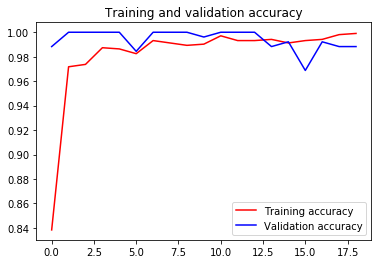

<Figure size 432x288 with 0 Axes>

In [13]:
# plot training and validation accuracy

%matplotlib inline
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()